# Step2 NBRA NA-MD with Quantum Espresso
![image info](./thumb0.png)

## Table of contents
<a name="toc"></a>
1. [Importing Libra and other dependencies](#import)
2. [Overview of required files](#required_files)
3. [Adjustments to required files](#adjustments)  
    3.1. [x0.scf.in](#pw_inp)  
    3.2. [x0.exp.in](#exp_inp)  
    3.3. [submit_templ.slm](#submit)  
    3.4. [run_step2.py](#run_step2)  
4. [Run step2 using Quantum Espresso](#driver)
5. [Plotting step2 data](#plot_step2_data)  
    5.1. [Read step2 data](#extract_step2)  
    5.2. [Plot step2 data](#plot_step2)
6. [References](#references)  

### A. Learning objectives
* To be able to prepare the required files for computing the vibronic Hamiltonian
* To be able to understand the key parameters critical to the computation of the vibronic Hamiltonian
* To analyze and plot the properties of the vibronic Hamiltonian, such as the time-dependent Kohn-Sham energies and the time-averaged nonadiabatic couplings

### B. Use cases
* [Constructing the vibronic Hamiltonian from the QE MD calculations](#adjustments)
* [Reading the vibronic Hamiltonian data files to obtain its properties](#data_read)
* [Compute the time-averaged nonadiabatic couplings of the vibronic Hamiltonian](#data_stat)
* [Using matplotlib to visualize the properties of the vibronic Hamiltonian](#plot_step2)

### C. Functions

- `libra_py`
  - `workflows`
    -  `nbra`
      - `step2`
        - [`run`](#step2_run)
  
  - `QE_methods`
    - [`out2inp`](#out2inp)

  - `hpc_utils`
    - [`distribute`](#distribute)

  - `data_read`
    - [`get_data_sets`](#data_read)

  - `data_stat`
    - [`cmat_stat2`](#data_stat)

In this tutorial, we will be doing step2 of the NBRA NA-MD workflow. This tutorial is a direct continuation of step1 with Quantum Espresso. Just to quickly recap what has been done so far, we have computed a 100 fs molecular dynamics trajectory of rutile $TiO_2$ using the Quantum Espresso software package.

Now, we are going to reperform SCF calculations at each molecular geometry along the trajectory to obtain the wavefunctions for each timestep. These wavefunctions will be used to construct the vibronic hamiltonian. The computation of the vibronic Hamiltonian is as follows:

$$
\Large H_{vibronic}(t) = 
\left(\begin{array}{cc} 
\frac{E_{0}(t)+E_{0}(t+dt)}{2} & . . . & d_{0N}\\
. . . &  & . . .\\
d_{N0} & . . . & \frac{E_{N}(t)+E_{N}(t+dt)}{2}
\end{array}\right)
$$

Where $\large d_{ij}$ is computed numerically accodring to the formulation of Hammes‐Schiffer and Tully $ ^1$:

## 1. Importing Libra and other dependencies <a name="import"></a>
[Return to Table of contents](#toc)

We begin by importing Libra and other dependencies that will be needed at a later time

In [82]:
from liblibra_core import *
from libra_py import *
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

## 2. Overview of required files <a name="required_files"></a>
[Return to Table of contents](#toc)

The following files are needed to run the Step 2 calculations
List of needed files
* `x0.scf.in` 
* `x0.exp.in`
* `x0.md.out`
* `submit_templ.slm`
* `run_step2.py`

Below, we list a brief summary of each file, along with a few helpful hints that may help avoid some of the most common types of errors:

* `x0.scf.in` 

Input file for the pw.x program. Make sure that the variable “prefix” in the &CONTROL namelist of this file is set to “x0”. Make sure that the ATOMIC_POSITIONS card is complete deleted. The last declared card in your input file should be CELL_PARAMETERS.

* `x0.exp.in`

Input file for the wavefunction export program. Make sure that the variable “prefix” is set to “x0”. Also make sure the pseudopotentials match exactly what is declared in the x0.scf.in file. 

* `x0.md.out`

Output from the molecular dynamics calculation using Quantum Espresso. Alternatively, this could be any .xyz input file. 

* `submit_templ.slm`

SLURM-style submit file used for running the step2 calculations. This file does not need to be a SLURM file, however. The indexing of the bands in this file starts from 1. Set “nac_method = 0” for spin-unpolarized calculations, “nac_method = 1” for spin-polarized, and “nac_method = 2” for spin-non-colinear. Be sure to set the path to the res directory to the directory which has this file in it. 

* `run_step2.py`

This file contains calls to functions that parse your molecular dynamics output file into various independent jobs. Here, if you your output from the molecular dynamics calculation is an .xyz file, use the function “QE_methods.xyz2inp(…)”. Otherwise, use the function “QE_methods. out2inp(…)”. In both functions, the first argument must be the name of the molecular dynamics output file. 


## 3. Adjustments to required files <a name="adjustments"></a>
[Return to Table of contents](#toc)

In order to construct the vibronic Hamiltonian from the QE MD calculations, we must first make sure that we have all of the required input files. After reading the previous section of the overview of the required files, we now will create them from scratch. 

### 3.1. x0.scf.in <a name="pw_inp"></a>
[Return to Table of contents](#toc)

Please see the tutorital for [step1 with Quantum Espresso](../2_step1_qe) for an overview of the parameters for this file . Also, for a complete description, please see the quantum espresso [pw.x input description](https://www.quantum-espresso.org/Doc/INPUT_PW.html). The pseudopotentials used herein can be found by visitin the quantum espresso [pseudopotential table](https://www.quantum-espresso.org/pseudopotentials).

The user will most likely need to change the following:
* Change the variable `pseudo_dir` to be the location where your pseudopotentials are located
* Change the pseudopotentials for Ti and O to be the pseudopotentials you have chosen to use

Overall, it is advised that nothing more be changed

In [83]:
scf_inp = \
"""&CONTROL
  calculation   = 'scf',
  pseudo_dir    = '/util/academic/espresso/6.2.1/pseudopotentials/upf_files/',
  outdir        = './',
  prefix        = 'x0',
  disk_io       = 'low',
/

&SYSTEM
  ibrav       = 0,
  nat         = 25,
  ntyp        = 4,
  nspin       = 1,
  nbnd        = 100
  ecutwfc     = 30,
  ecutrho     = 300,
  occupations = 'smearing',
  smearing    = 'gaussian',
  degauss     = 0.01,
  nosym       = true,
/

&ELECTRONS
  electron_maxstep = 300,
  conv_thr         = 1.D-4,
  mixing_beta      = 0.30,
/

ATOMIC_SPECIES
C  12.010     C.pbe-n-rrkjus_psl.0.1.UPF 
H  1.007      H.pbe-rrkjus_psl.0.1.UPF 
Ir 192.217    Ir.pbe-n-rrkjus_psl.0.2.3.UPF
N  14.006     N.pbe-n-rrkjus_psl.0.1.UPF

K_POINTS gamma

CELL_PARAMETERS  angstrom
        7.0652699470        0.0000000000         0.0000000000
        0.0000000000        7.0652699470         0.0000000000
        0.0000000000        0.0000000000         7.0652699470 

"""

### 3.2. x0.exp.in <a name="exp_inp"></a>
[Return to Table of contents](#toc)

Input file for the pw_export package within the Quantum Espresso suite. For a more complete description, please see the quantum espresso [pw_export.x input description](https://www.quantum-espresso.org/Doc/INPUT_pw_export.html).

Similar to the case of section [3.1. x0.scf.in](#pw_inp), the user will most likely need to change the following:
* Change the variable `pseudo_dir` to be the location where your pseudopotentials are located
* Change the pseudopotentials for Ti and O to be the pseudopotentials you have chosen to use

Overall, it is advised that nothing more be changed

In [84]:
exp_inp = \
"""&inputpp
  prefix      = 'x0',
  outdir      = './',
  pseudo_dir  = '/util/academic/espresso/6.2.1/pseudopotentials/upf_files',
  psfile(1) =  C.pbe-n-rrkjus_psl.0.1.UPF 
  psfile(2) =  H.pbe-rrkjus_psl.0.1.UPF
  psfile(3) =  Ir.pbe-n-rrkjus_psl.0.2.3.UPF
  psfile(4) =  N.pbe-n-rrkjus_psl.0.1.UPF
  single_file = .FALSE.,
  ascii       = .TRUE.,
  uspp_spsi   = .FALSE.,
/
"""

### 3.3. submit_templ.slm <a name="submit"></a>
[Return to Table of contents](#toc)

The submit file in the SLURM enviornment for computing the vibronic Hamiltonian.

* `BATCH_SYSTEM` - option for parallel execution of the SCF calculations
* `NP` - number of cores for each SCF calculations
* `EXE , EXE_EXPORT , EXE_CONVERT` - executables for the various sub-packages in the Quantum Espresso suite
* `start_indx` - starting time index of a particular batch of SCF calculations
* `stop_indx` - ending time index of a particular batch of SCF calculations
* `wd` - working directory to store the the files generated by each sub-package in the Quantum Espresso suite
* `rd` - results directory to store the outputs, such as the vibronic Hamiltonian, overlap matricies, etc.
* `dt` - nuclear integration time step of the molecular dynamics
* `minband` - index of the lowest  eigenvalue to be considered in the vibronic Hamiltonian for non spin-orbit couping case
* `maxband` - index of the highest eigenvalue to be considered in the vibronic Hamiltonian for non spin-orbit couping case
* `minband_soc` - index of the lowest eigenvalue to be considered in the vibronic Hamiltonian for spin-orbit couping case
* `maxband_soc` - index of the highest eigenvalue to be considered in the vibronic Hamiltonian for spin-orbit couping case
* `nac_method` - 0 for spin-restricted, 1 for spin-unrestricted, 2 for spin-non-colinear
* `orthogonalize` - 1 to orthoganlize the wavefunctions. otherwise 0
* `prefix0` - prefix of the pw.x and pw_export.x input and output files
* `compute_Hprime` - option to compute transition dipole matricies. Currently under development, set to 0 for now 
* `verbosity` - set to 1 to include addition output

Because we are using a Jupyter Notebook, there are a few extra things we must do. We must include "--export=All" when setting the variable NPROCS in bash as well as for the "batch_system" parameter. Also, we include two backslashes "\\" when defining the parameters dictionary. 

The user will most likely need to change the following:
* Change the variable `--mail-user=` to be the email of the user
* Change the version of Quantum Espresso to be the current version you are using when loading the module, this is seen in `module load espresso/6.2.1`
* Change the variable `NP` to be the number of CPU cores you are using. In this case, it is equal to `#SBATCH --ntasks-per-node`

Overall, it is advised that nothing more be changed
<a name="step2_run"></a>

In [85]:
submit_inp = \
"""#!/bin/sh
#SBATCH --partition=valhalla --qos=valhalla
#SBATCH --cluster=faculty
###SBATCH --partition=scavenger --qos=scavenger
###SBATCH --cluster=faculty
###SBATCH --requeue
#SBATCH --time=6:00:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=12
#SBATCH --mem=20000
#SBATCH --mail-user=bsmith24@buffalo.edu

echo "SLURM_JOBID="$SLURM_JOBID
echo "SLURM_JOB_NODELIST="$SLURM_JOB_NODELIST
echo "SLURM_NNODES="$SLURM_NNODES
echo "SLURMTMPDIR="$SLURMTMPDIR
echo "working directory="$SLURM_SUBMIT_DIR

NPROCS=`srun --export=ALL --nodes=${SLURM_NNODES} bash -c 'hostname' |wc -l`
echo NPROCS=$NPROCS

module load espresso/6.2.1

#The PMI library is necessary for srun
export I_MPI_PMI_LIBRARY=/usr/lib64/libpmi.so

# Setup all manual parameters here
# Must be ABSOLUTE paths
NP=12
exe_qespresso=/util/academic/espresso/6.2.1/bin/pw.x
exe_export=/util/academic/espresso/6.2.1/bin/pw_export.x
exe_convert=/util/academic/espresso/6.2.1/bin/iotk
batch_system="srun --export=All"
res=$PWD/../../res

# These will be assigned automatically, leave them as they are
param1=
param2=

# This is invocation of the scripts which will further handle NA-MD calclculations
# on the NAC calculation step
# NOTE: minband - starting from 1
#       maxband - is included

python -c "from libra_py.workflows.nbra import step2
params = { }
params[\\"BATCH_SYSTEM\\"]=\\"$batch_system\\"
params[\\"NP\\"]=$NP
params[\\"EXE\\"]=\\"$exe_qespresso\\"
params[\\"EXE_EXPORT\\"]=\\"$exe_export\\"
params[\\"EXE_CONVERT\\"] =\\"$exe_convert\\"
params[\\"start_indx\\"]=\\"$param1\\"
params[\\"stop_indx\\"]=\\"$param2\\"
params[\\"wd\\"]=\\"wd\\"
params[\\"rd\\"]=\\"$res\\"
params[\\"dt\\"]=41.34145
params[\\"minband\\"]=70
params[\\"maxband\\"]=100
params[\\"minband_soc\\"]=70
params[\\"maxband_soc\\"]=100
params[\\"nac_method\\"]=0
params[\\"orthogonalize\\"]=1
params[\\"prefix0\\"]=\\"x0.scf\\"
params[\\"compute_Hprime\\"]=0
params[\\"verbosity\\"]=1
print( params )
step2.run(params)
"
"""


### 3.4. run_step2.py <a name="run_step2"></a>
[Return to Table of contents](#toc)

This script is the driver script for the dynamics. The functions called herein distribute the job batches into their respective folders and submit the jobs for computation

* `tot_nsteps` - total number of molecular dynamics timesteps to consider
* `nsteps_per_job` - how many molecular dynamics timesteps to consider per job batch 
* `QE_methods.out2inp` - appends the atomic positions from the molecular dynamics output to each SCF inputfile
* `hpc_utils.distribute` - distributes the each batch of jobs to their respective working directories, submits the jobs

It is advised that nothing more be changed in this script
<a name="out2inp"></a>
<a name="distribute"></a>

In [86]:
run_step2_inp = \
"""import os
import sys
import time
import math

# Fisrt, we add the location of the library to test to the PYTHON path
if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import *

# Remove the previous results and temporary working directory from the previous runs
os.system("rm -r res")
os.system("rm -r wd")
os.system("mkdir res")

tot_nsteps     = 100
nsteps_per_job = 10
# tot_nsteps = total simulation time (from 0!)
# tot_nsteps / nsteps_per_job = total number of jobs submitted

# For non-SOC
QE_methods.out2inp("x0.md.out","x0.scf.in","wd","x0.scf",0,tot_nsteps,1)
os.system("cp submit_templ.slm wd"); os.system("cp x0.exp.in wd"); os.chdir("wd")
hpc_utils.distribute(0,tot_nsteps,nsteps_per_job,"submit_templ.slm",["x0.exp.in"],["x0.scf"],2)

#For SOC
#QE_methods.out2inp("x0.md.out","x1.scf.in","wd","x1.scf",0,tot_nsteps,1)
#os.system("cp submit_templ.slm wd"); os.system("cp x1.exp.in wd"); os.chdir("wd")
#hpc_utils.distribute(0,tot_nsteps,nsteps_per_job,"submit_templ.slm",["x1.exp.in"],["x1.scf"],2)
"""

Generate the required files by writing them

In [87]:
#!cp ../../step1/x0.md.out .
f = open("x0.scf.in","w")
f.write(scf_inp)
f.close()
f = open("x0.exp.in","w"); f.write(exp_inp); f.close()
f = open("submit_templ.slm","w"); f.write(submit_inp); f.close()
f = open("run_step2.py","w"); f.write(run_step2_inp); f.close()

## 4. Run step2 using Quantum Espresso <a name="driver"></a>
[Return to Table of contents](#toc)

In [88]:
!python run_step2.py

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

## 5. Plotting step2 data<a name="plot_step2_data"></a>
[Return to Table of contents](#toc)

Before running this section, be sure that the step2 calculations have completely finished. It may take a few minutes to complete. 

### 5.1. Read step2 data <a name="extract_step2"></a>
[Return to Table of contents](#toc)

We now extract the data needed to plot the time-dependent kohn-sham energies and the time-averaged nonadiabatic ouplings between them. To begin, we first need to read the data (that is, read the vibronic Hamiltonian matrix files). To do this, we will utilize Libra's `data_read` module. Specifically, we will be using the `get_data_sets` function within this module. For a more complete tutorial on using Libra's `data_read` module, please see the [tutorial for Libra's data_read module](https://github.com/compchem-cybertraining/Tutorials_Libra/issues/7) 
<a name="data_read"></a>

In [77]:
import os
cwd = os.getcwd()
num_alpha_ks_orbs =     ##############################################
data_dim    = 2*num_alpha_ks_orbs
act_sp      = range(data_dim)
res_dir     = cwd+"/res/"
dt          = 1.0*units.fs2au
start_time  = 0
finish_time = 99
params = { "data_set_paths" : [res_dir],
           "active_space":act_sp,  "dt":dt, "data_dim":data_dim,
           "isnap":start_time,  "fsnap":finish_time,
           "data_re_prefix" : "hvib_dia_", "data_re_suffix" : "_re",
           "data_im_prefix" : "hvib_dia_", "data_im_suffix" : "_im",
         }

print ("\nGathering the data ...")
start = time.time()
Hvib_ks = data_read.get_data_sets(params)
end = time.time()
print ("Complete")
print ("Time to complete: ", end - start)


Gathering the data ...
Complete
Time to complete:  0.28029918670654297


Now that we have read the vibronic Hamiltonian matrix files, we must compute the time-averaged nonadiabatic couplings for each pair of nonadiabatic couplings. We can do this using Libra's `data_stat` module. Specifically, we will be using the `cmat_stat2` function within this module. For a more complete tutorial on using Libra's `data_stat` module, please see the [tutorial for Libra's data_stat module](https://github.com/compchem-cybertraining/Tutorials_Libra/issues/8) 

<a name="data_stat"></a>

In [78]:
ntraj  = len(Hvib_ks)
nsteps = len(Hvib_ks[0])
ks_res = data_stat.cmat_stat2(Hvib_ks[0], 2)

Now, let's make the lists of the data needed for plotting with matplotlib

In [79]:
ks_tNACs = []
ks_orbs_to_print = range(int(data_dim/2))
#ks_orbs_to_print = range(int(data_dim/2), data_dim)
#ks_orbs_to_print = range(data_dim)
md_time = list(range(nsteps))

KS_energy = []
for ks_index in range( num_alpha_ks_orbs ):
    KS_energy.append( [] )
    for step in range( nsteps ):
        #print( Hvib_ks[ 0 ][ step ].get( ks_index, ks_index ).real )
        KS_energy[ ks_index ].append( Hvib_ks[ 0 ][ step ].get( ks_index, ks_index ).real )
        
for i in ks_orbs_to_print:
    ks_tNACs.append( [] )
    for j in ks_orbs_to_print:
        ks_tNACs[i].append( ks_res.get(i,j).imag * 1000.0 / units.ev2Ha )

### 5.2. Plot step2 data <a name="plot_step2"></a>
[Return to Table of contents](#toc)

We now will plot the time-dependent kohn-sham energies and the time-averaged nonadiabatic ouplings between them

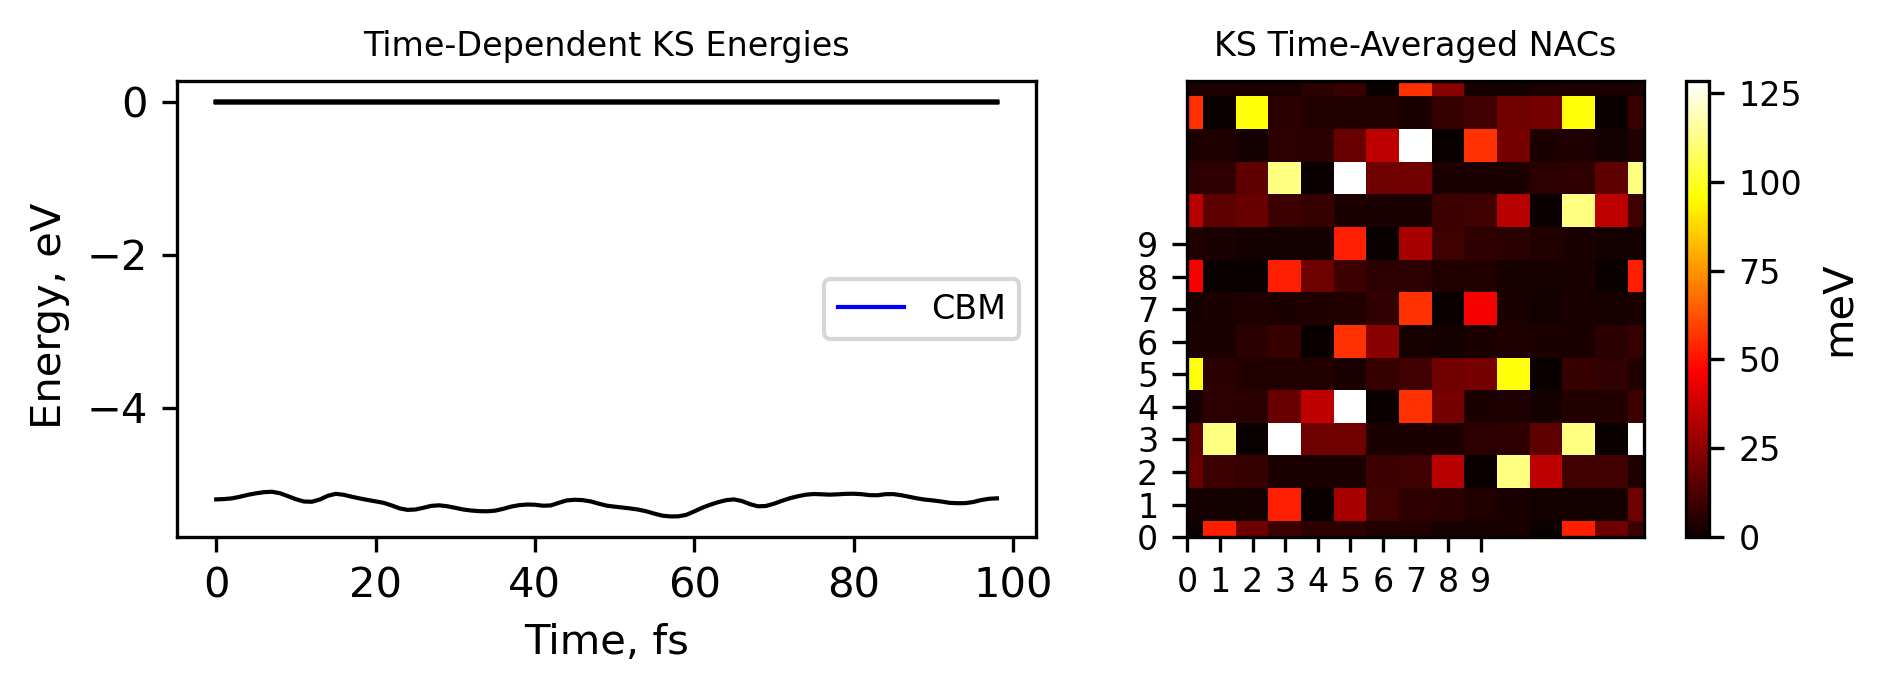

In [80]:
KS_energy = np.array( KS_energy  )
ks_tNACs  = np.array(ks_tNACs)
plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,2,1)
plt.title('Time-Dependent KS Energies', fontsize=8)
plt.xlabel('Time, fs')
plt.ylabel('Energy, eV ')
for ks_index in ks_orbs_to_print:
    if ks_index == 1:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="VBM", linewidth=1, color = "blue")
    elif ks_index == 2:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="CBM", linewidth=1, color = "red")
    else:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="", linewidth=1, color = "black")
plt.legend(fontsize=8)
plt.tight_layout()

plt.subplot(1,2,2)
plt.title('KS Time-Averaged NACs', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,num_alpha_ks_orbs-1)
plt.ylim(0,num_alpha_ks_orbs-1)
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.imshow(ks_tNACs, cmap='hot', interpolation='nearest')
cb = plt.colorbar(label="meV")
cb.ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

## References<a name="references"></a>
[Return to Table of contents](#toc)

1. Hammes‐Schiffer, S.; Tully, J. C. Proton Transfer in Solution: Molecular Dynamics with Quantum Transitions. J. Chem. Phys. 1994, 101 (6), 4657–4667.